### Imports

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


### Funções

In [2]:
def load_data(file_path):
    return pd.read_parquet(file_path)

def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

def create_classification_report_df(class_reports,model_names):
    if len(class_reports) != len(model_names):
        raise ValueError("O número de relatórios de classificação deve ser igual ao número de nomes de modelos.")

    all_reports = []

    for report, model_name in zip(class_reports, model_names):
        # Verificar se as chaves esperadas existem no relatório
        data = {
            'Model': model_name,
            'Accuracy': report.get('accuracy', None),
            'Class 0 Precision': report.get('0', {}).get('precision', None),
            'Class 0 Recall': report.get('0', {}).get('recall', None),
            'Class 0 F1-Score': report.get('0', {}).get('f1-score', None),
            'Class 1 Precision': report.get('1', {}).get('precision', None),
            'Class 1 Recall': report.get('1', {}).get('recall', None),
            'Class 1 F1-Score': report.get('1', {}).get('f1-score', None),
            'Class 2 Precision': report.get('2', {}).get('precision', None),
            'Class 2 Recall': report.get('2', {}).get('recall', None),
            'Class 2 F1-Score': report.get('2', {}).get('f1-score', None),
            'Macro Avg Precision': report.get('macro avg', {}).get('precision', None),
            'Macro Avg Recall': report.get('macro avg', {}).get('recall', None),
            'Macro Avg F1-Score': report.get('macro avg', {}).get('f1-score', None),
            'Weighted Avg Precision': report.get('weighted avg', {}).get('precision', None),
            'Weighted Avg Recall': report.get('weighted avg', {}).get('recall', None),
            'Weighted Avg F1-Score': report.get('weighted avg', {}).get('f1-score', None)
        }
        all_reports.append(data)

    return pd.DataFrame(all_reports)
def evaluate_feature_importance(model, x_train, x_test, y_train, y_test):
    accuracies = []
    features = x_train.columns
    for feature in features:
        x_train_temp = x_train.drop(columns=[feature])
        x_test_temp = x_test.drop(columns=[feature])
        model.fit(x_train_temp, y_train)
        y_pred_temp = model.predict(x_test_temp)
        accuracy = accuracy_score(y_test, y_pred_temp)
        accuracies.append((feature, accuracy))
    return accuracies

def evaluate_model(model, x_train, x_test, y_train, y_test):
    """
    Avalia um modelo e retorna as métricas de desempenho para treino e teste.

    Args:
        model: O modelo a ser avaliado.
        x_train: Dados de treino.
        x_test: Dados de teste.
        y_train: Rótulos de treino.
        y_test: Rótulos de teste.

    Returns:
        Um dicionário com as métricas de desempenho.
    """

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train, y_pred_train),
            'precision': precision_score(y_train, y_pred_train, average='macro'),
            'recall': recall_score(y_train, y_pred_train, average='macro'),
            'f1': f1_score(y_train, y_pred_train, average='macro')
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_pred_test),
            'precision': precision_score(y_test, y_pred_test, average='macro'),
            'recall': recall_score(y_test, y_pred_test, average='macro'),
            'f1': f1_score(y_test, y_pred_test, average='macro')
        }
    }

    return metrics



### Carregando dados

In [3]:
seed = 42
file_path = '../data/outputs/costumers_feature_df.parquet'
file_path2 = '../data/outputs/feature_df.parquet'
file_path3 = '../data/outputs/finale_df.parquet'
df = load_data(file_path3)
##display(df)

rating = df['review_score_factor']
#rating = df['review_score']

drop_columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 'review_comment_title', 'review_score', \
                'review_creation_date', 'review_comment_message', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'customer_unique_id', \
                'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', \
                'freight_value', 'product_category_name', 'product_length_cm', 'product_height_cm', 'product_width_cm', \
                'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_score_factor']

features = df.drop(drop_columns, axis=1)
features = features.fillna(features.mean())

In [4]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,polarity,review_score_factor,price_factor,freight_value_factor,if_delivered,actual_est_delivery_diff,delivery_duration,delivery_time_diff,delivery,satisfaction
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,1,1.0,0.0,0.0,1.0,7.0,8.0,-8.0,1,1
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,1,1.0,0.0,0.0,1.0,7.0,8.0,-8.0,1,1
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,1,1.0,0.0,0.0,1.0,7.0,8.0,-8.0,1,1
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,b46f1e34512b0f4c74a72398b03ca788,4,...,1,1.0,0.0,0.0,1.0,9.0,2.0,-10.0,1,1
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,dc90f19c2806f1abba9e72ad3c350073,5,...,1,2.0,0.0,0.0,1.0,7.0,5.0,-8.0,1,1


### Dividindo os dados

In [5]:

x_train, x_test, y_train, y_test = train_test_split(features, rating, test_size = 0.2, random_state = seed)

### Criação e treinamento do modelo de XGBoost

c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.8148595590456056
Classification Report:
{'0.0': {'precision': 0.9666329625884732, 'recall': 0.9975652173913043, 'f1-score': 0.9818555289284492, 'support': 2875.0}, '1.0': {'precision': 0.695024077046549, 'recall': 0.3724731182795699, 'f1-score': 0.4850182021842621, 'support': 2325.0}, '2.0': {'precision': 0.7622377622377622, 'recall': 0.9211916332136066, 'f1-score': 0.8342102745623267, 'support': 4733.0}, 'accuracy': 0.8148595590456056, 'macro avg': {'precision': 0.8079649339575948, 'recall': 0.7637433229614937, 'f1-score': 0.7670280018916794, 'support': 9933.0}, 'weighted avg': {'precision': 0.8056651641242741, 'recall': 0.8148595590456056, 'f1-score': 0.7952098253549978, 'support': 9933.0}}


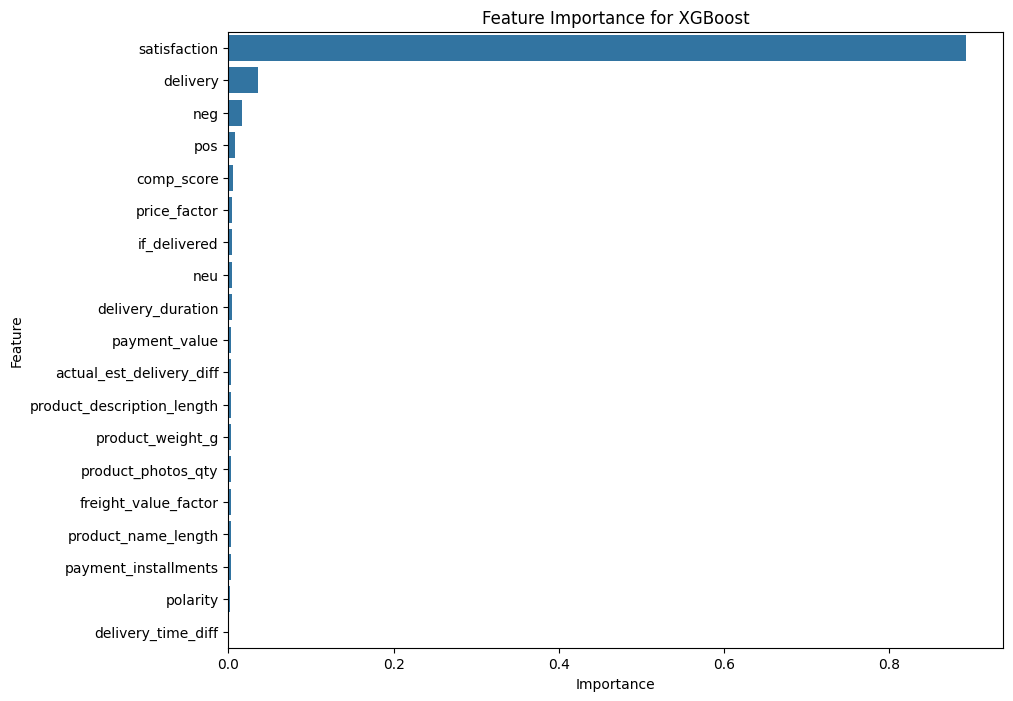

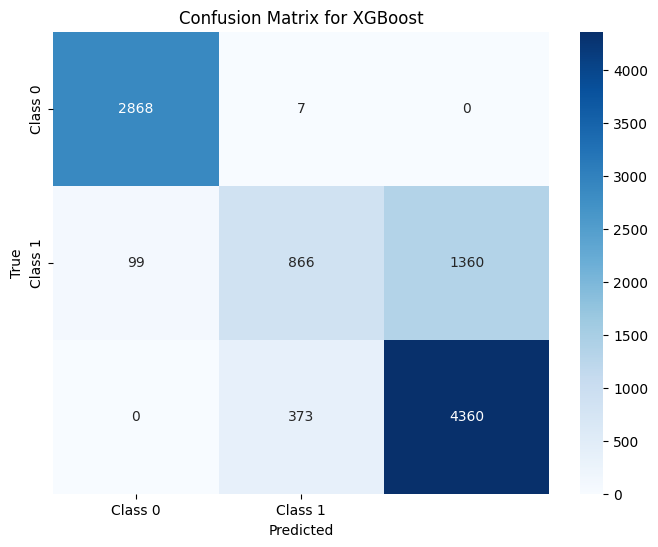

In [6]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit model
xgb_model.fit(x_train, y_train)

# Make predictions
y_pred = xgb_model.predict(x_test)

# Evaluate model
accuracy_xgb = accuracy_score(y_test, y_pred)
conf_matrix_xgb = confusion_matrix(y_test, y_pred)
class_report_xgb = classification_report(y_test, y_pred, output_dict=True)

print("XGBoost Model")
print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:")
print(class_report_xgb)

# Feature Importance for XGBoost
importance = xgb_model.feature_importances_
features_names = x_train.columns
importance_df = pd.DataFrame({'Feature': features_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for XGBoost')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo de Árvore de decisão

{'0.0': {'precision': 0.9666329625884732, 'recall': 0.9975652173913043, 'f1-score': 0.9818555289284492, 'support': 2875.0}, '1.0': {'precision': 0.695024077046549, 'recall': 0.3724731182795699, 'f1-score': 0.4850182021842621, 'support': 2325.0}, '2.0': {'precision': 0.7622377622377622, 'recall': 0.9211916332136066, 'f1-score': 0.8342102745623267, 'support': 4733.0}, 'accuracy': 0.8148595590456056, 'macro avg': {'precision': 0.8079649339575948, 'recall': 0.7637433229614937, 'f1-score': 0.7670280018916794, 'support': 9933.0}, 'weighted avg': {'precision': 0.8056651641242741, 'recall': 0.8148595590456056, 'f1-score': 0.7952098253549978, 'support': 9933.0}}


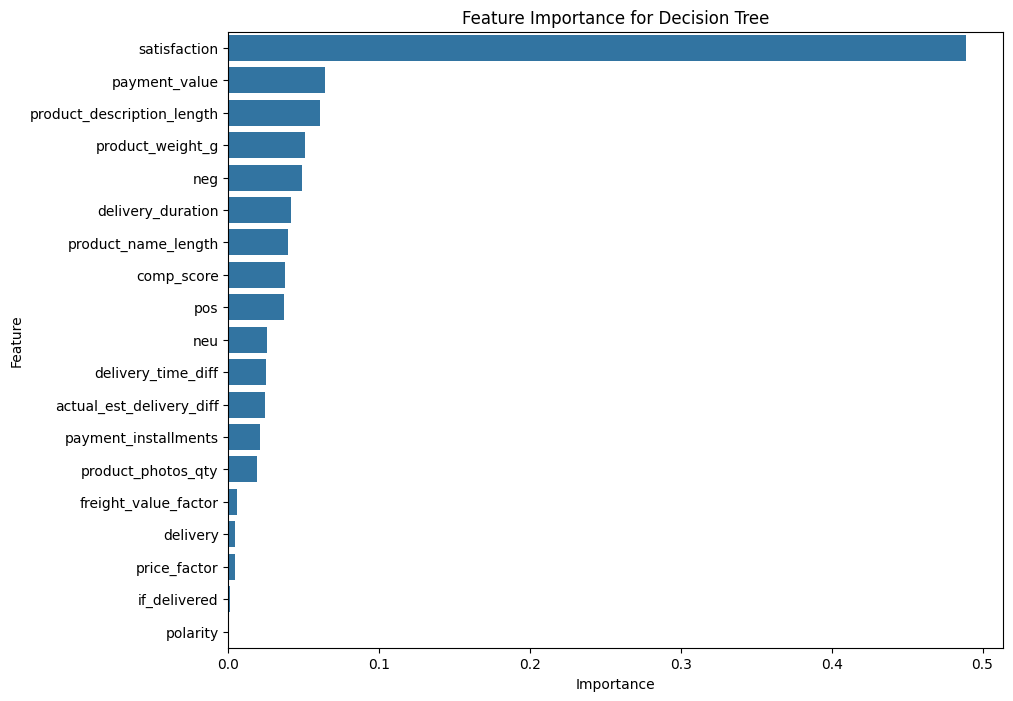

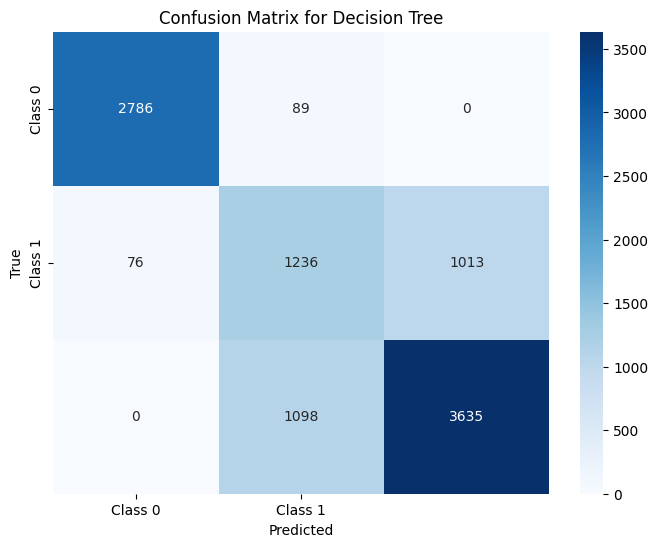

In [7]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

# Realização de previsões
y_pred_dt = clf.predict(x_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred,output_dict=True)
print(class_report_dt)

importance_dt = clf.feature_importances_
importance_df_dt = pd.DataFrame({'Feature': features_names, 'Importance': importance_dt})
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_dt)
plt.title('Feature Importance for Decision Tree')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo de regressão logística

{'0.0': {'precision': 0.7779935275080906, 'recall': 0.8361739130434782, 'f1-score': 0.806035205364627, 'support': 2875.0}, '1.0': {'precision': 0.40499457111834963, 'recall': 0.16043010752688172, 'f1-score': 0.22982131854590265, 'support': 2325.0}, '2.0': {'precision': 0.6865923674434313, 'recall': 0.8590745827170928, 'f1-score': 0.7632097606757391, 'support': 4733.0}, 'accuracy': 0.6889157354273633, 'macro avg': {'precision': 0.6231934886899572, 'recall': 0.6185595344291509, 'f1-score': 0.5996887615287563, 'support': 9933.0}, 'weighted avg': {'precision': 0.6471343445631415, 'recall': 0.6889157354273633, 'f1-score': 0.6507558218383972, 'support': 9933.0}}


c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


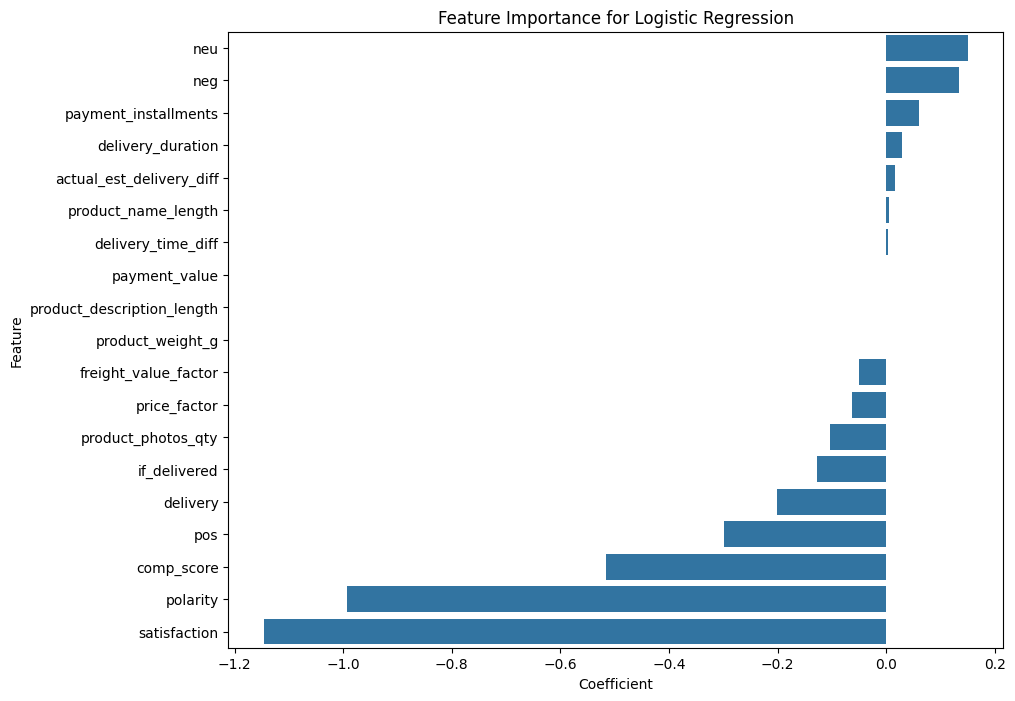

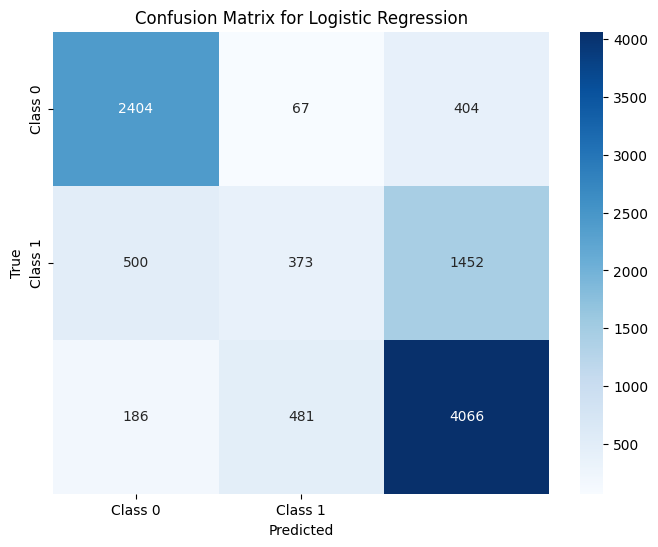

In [8]:
# Criar e treinar o modelo de regressão logística
model = LogisticRegression(max_iter=1000, random_state=seed)
model.fit(x_train, y_train)

# Fazer previsões e avaliar o modelo
y_pred_lr = model.predict(x_test)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
class_report_lr = classification_report(y_test, y_pred_lr,output_dict=True)
print(class_report_lr)

coefficients = model.coef_[0]
importance_lr_df = pd.DataFrame({'Feature': features_names, 'Coefficient': coefficients})
importance_lr_df = importance_lr_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_lr_df)
plt.title('Feature Importance for Logistic Regression')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo com regressão linear

In [9]:

reg = lm.LinearRegression().fit(x_train, y_train)

y_pred_lr = reg.predict(x_test)

score = reg.score(x_test, y_test)
rmse_lr = np.sqrt(mean_squared_error(y_test.values, y_pred_lr))

print(f'The R2 score in this linear regression model is {round(score, 5)}')
print(f'The RMSE in this linear regression model is {round(rmse_lr, 5)}, which is about {100*round(rmse_lr/np.mean(rating),2)}% of \
the mean rating score.')

The R2 score in this linear regression model is 0.79368
The RMSE in this linear regression model is 0.38834, which is about 33.0% of the mean rating score.


### Criação e treinamento do modelo com floresta aleatória

The accuracy of the RF model is 0.84053
Classification Report for Random Forest:
{'0.0': {'precision': 0.9666666666666667, 'recall': 0.9986086956521739, 'f1-score': 0.9823781009409752, 'support': 2875.0}, '1.0': {'precision': 0.7614678899082569, 'recall': 0.46408602150537637, 'f1-score': 0.5766969535008017, 'support': 2325.0}, '2.0': {'precision': 0.793184276956365, 'recall': 0.9294316501162053, 'f1-score': 0.8559198365599766, 'support': 4733.0}, 'accuracy': 0.840531561461794, 'macro avg': {'precision': 0.8404396111770961, 'recall': 0.7973754557579186, 'f1-score': 0.8049982970005845, 'support': 9933.0}, 'weighted avg': {'precision': 0.8359730890504217, 'recall': 0.840531561461794, 'f1-score': 0.827164607221689, 'support': 9933.0}}


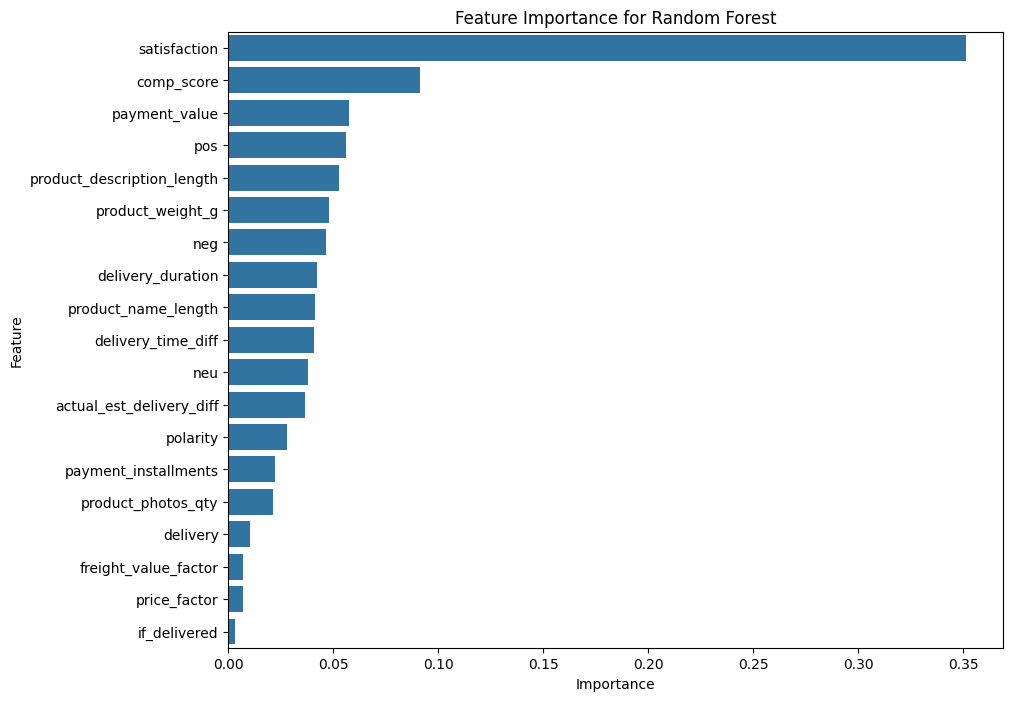

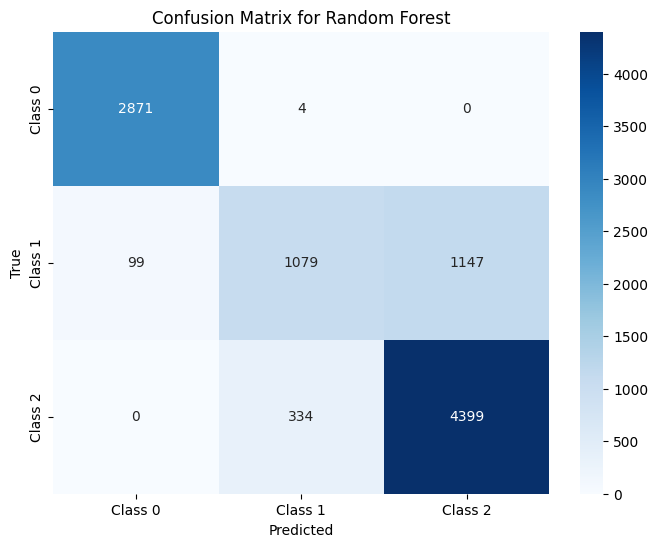

In [10]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=seed)

# Ajuste o modelo com os dados de treinamento
model_rf.fit(x_train, y_train)

# Fazer previsões
y_pred_rf = model_rf.predict(x_test)

# Avaliar o modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(f'The accuracy of the RF model is {round(accuracy_rf, 5)}')

# Exibir relatório de classificação
class_report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
print("Classification Report for Random Forest:")
print(class_report_rf)

# Feature Importance for Random Forest
# Certifique-se de que o modelo foi ajustado corretamente antes de acessar 'feature_importances_'
importance_rf = model_rf.feature_importances_
features_names = x_train.columns  # Obtendo os nomes das características

# Criação do DataFrame para importâncias
importance_df_rf = pd.DataFrame({'Feature': features_names, 'Importance': importance_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Plotagem da importância das características
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Feature Importance for Random Forest')
plt.show()

# Plotagem da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo utilizando KNN

The accuracy of the KNN model is 0.49532
{'0.0': {'precision': 0.4667322189446083, 'recall': 0.49530434782608695, 'f1-score': 0.48059399257509283, 'support': 2875.0}, '1.0': {'precision': 0.33678220382824625, 'recall': 0.28, 'f1-score': 0.3057773602630343, 'support': 2325.0}, '2.0': {'precision': 0.5748636088098605, 'recall': 0.6010986689203465, 'f1-score': 0.5876884941127866, 'support': 4733.0}, 'accuracy': 0.49531863485351857, 'macro avg': {'precision': 0.4594593438609051, 'recall': 0.4588010055821445, 'f1-score': 0.4580199489836379, 'support': 9933.0}, 'weighted avg': {'precision': 0.4878388416252382, 'recall': 0.49531863485351857, 'f1-score': 0.49070469484554174, 'support': 9933.0}}


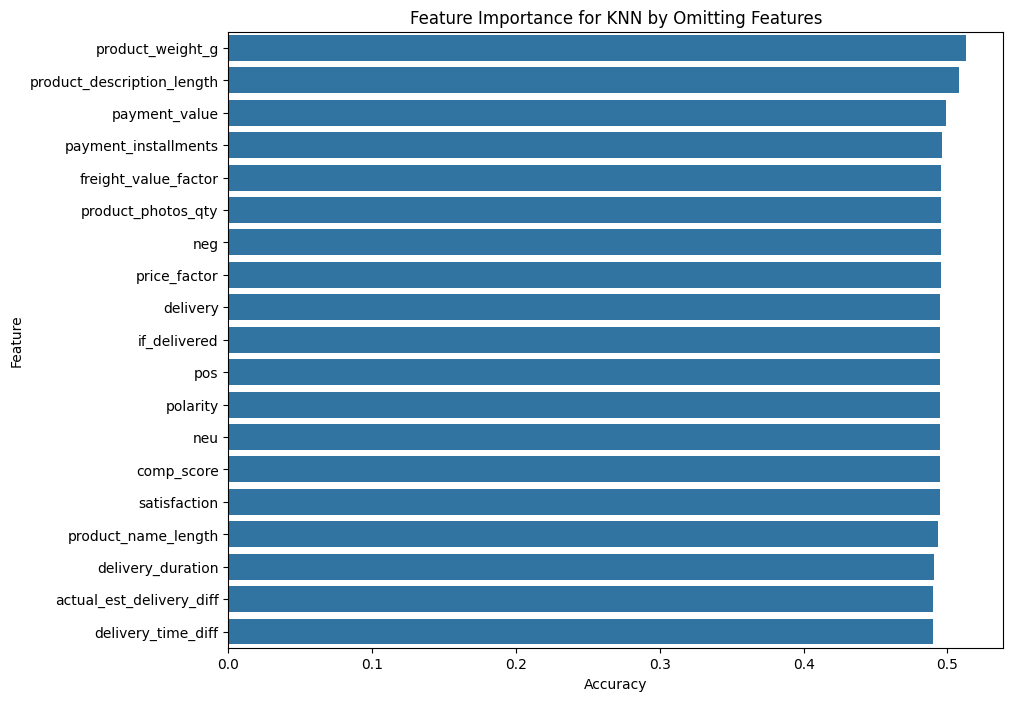

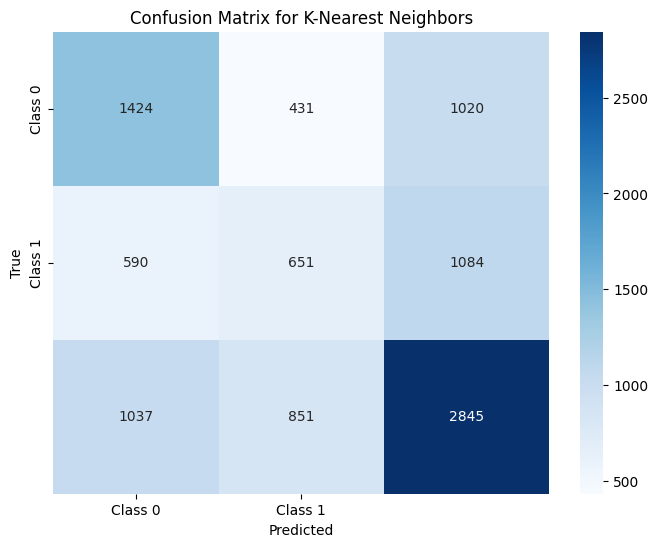

In [11]:
# Criar e treinar o modelo K-Nearest Neighbors
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(x_train, y_train)

# Fazer previsões
y_pred_knn = model_knn.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(f'The accuracy of the KNN model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_knn = classification_report(y_test, y_pred_knn,output_dict=True)
print(class_report_knn)

feature_importance_knn = evaluate_feature_importance(model_knn, x_train, x_test, y_train, y_test)
importance_df_knn = pd.DataFrame(feature_importance_knn, columns=['Feature', 'Accuracy'])
importance_df_knn = importance_df_knn.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Accuracy', y='Feature', data=importance_df_knn)
plt.title('Feature Importance for KNN by Omitting Features')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo utilizando GBM

The accuracy of the Gradient Boosting model is 0.79976
{'0.0': {'precision': 0.9618601538976246, 'recall': 1.0, 'f1-score': 0.9805593451568895, 'support': 2875.0}, '1.0': {'precision': 0.6647058823529411, 'recall': 0.29161290322580646, 'f1-score': 0.4053811659192825, 'support': 2325.0}, '2.0': {'precision': 0.7412221471978393, 'recall': 0.9277413902387492, 'f1-score': 0.824059303744018, 'support': 4733.0}, 'accuracy': 0.79975838115373, 'macro avg': {'precision': 0.7892627278161349, 'recall': 0.7397847644881853, 'f1-score': 0.7366666049400633, 'support': 9933.0}, 'weighted avg': {'precision': 0.7871734160488908, 'recall': 0.79975838115373, 'f1-score': 0.7713572951483767, 'support': 9933.0}}


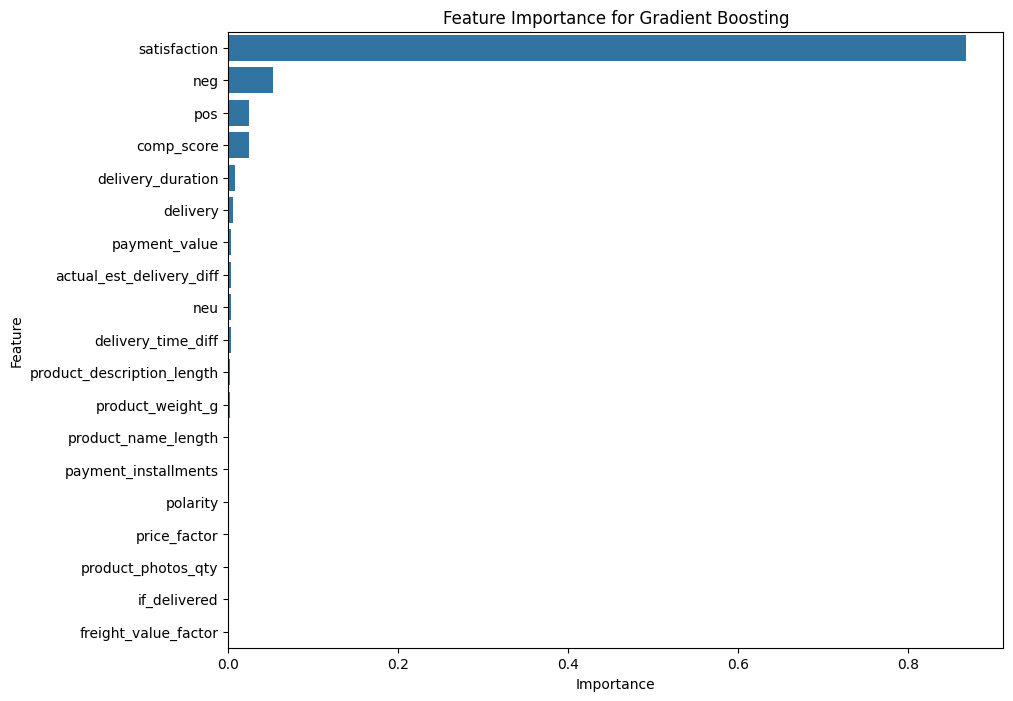

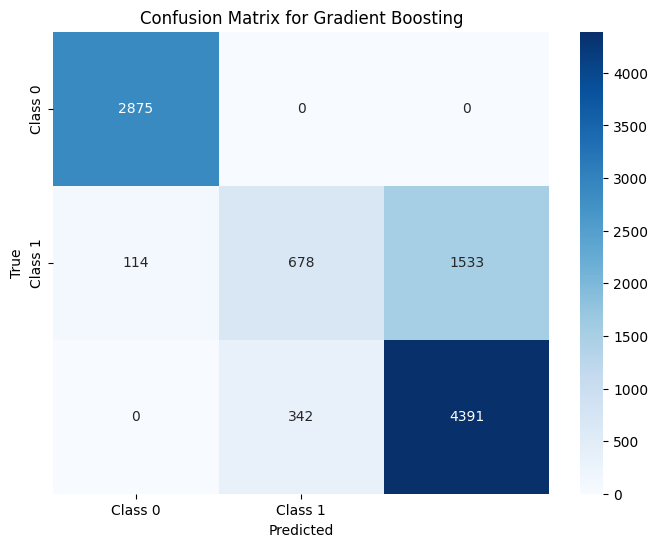

In [12]:
# Criar e treinar o modelo Gradient Boosting
model_gbm = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_gbm.fit(x_train, y_train)

# Fazer previsões
y_pred_gbm = model_gbm.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_gbm)
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
print(f'The accuracy of the Gradient Boosting model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_gbm = classification_report(y_test, y_pred_gbm,output_dict=True)
print(class_report_gbm)

# Feature Importance for Gradient Boosting
importance_gbm = model_gbm.feature_importances_
importance_df_gbm = pd.DataFrame({'Feature': features_names, 'Importance': importance_gbm})
importance_df_gbm = importance_df_gbm.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_gbm)
plt.title('Feature Importance for Gradient Boosting')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
# Lista de modelos e seus nomes
models = [
    ('Logistic Regression', model),
    ('Decision Tree', clf),
    ('Random Forest', model_rf),
    ('K-Nearest Neighbors', model_knn),
    ('Gradient Boosting', model_gbm),
    ('XGBoost', xgb_model)
]

# Lista para armazenar os resultados
results = []

# Avaliar cada modelo
for name, model in models:
    # Ensure the model is fitted with the same columns as the training data
    model.fit(x_train, y_train)
    metrics = evaluate_model(model, x_train, x_test, y_train, y_test)
    results.append({
        'Model': name,
        'Set': 'Train',
        'Accuracy': metrics['train']['accuracy'],
        'Precision': metrics['train']['precision'],
        'Recall': metrics['train']['recall'],
        'F1': metrics['train']['f1']
    })
    results.append({
        'Model': name,
        'Set': 'Test',
        'Accuracy': metrics['test']['accuracy'],
        'Precision': metrics['test']['precision'],
        'Recall': metrics['test']['recall'],
        'F1': metrics['test']['f1']
    })

# Criar um DataFrame a partir dos resultados
results_df = pd.DataFrame(results)
display(results_df)

c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Set,Accuracy,Precision,Recall,F1
0,Logistic Regression,Train,0.687682,0.623130,0.617449,0.598266
1,Logistic Regression,Test,0.688916,0.623193,0.618560,0.599689
2,Decision Tree,Train,0.999849,0.999784,0.999894,0.999839
3,Decision Tree,Test,0.770865,0.755204,0.756223,0.755617
4,Random Forest,Train,0.999849,0.999821,0.999858,0.999839
5,Random Forest,Test,0.840532,0.840440,0.797375,0.804998
6,K-Nearest Neighbors,Train,0.667472,0.644303,0.635930,0.638304
7,K-Nearest Neighbors,Test,0.495319,0.459459,0.458801,0.458020
8,Gradient Boosting,Train,0.806302,0.799132,0.747457,0.746629
9,Gradient Boosting,Test,0.799758,0.789263,0.739785,0.736667


In [16]:
results_df.to_parquet('results.parquet')

In [14]:
# prompt: Usando o DataFrame results_df: plot um gráfico que pra cada modelo tenha accuracy, precision, recall e f1 score

import altair as alt

alt.Chart(results_df).mark_bar().encode(
    x='Metric',
    y='Score',
    color='Set',
    column='Model'
)


ValueError: Unable to determine data type for the field "Metric"; verify that the field name is not misspelled. If you are referencing a field from a transform, also confirm that the data type is specified correctly.

alt.Chart(...)

In [15]:
# prompt: não gostei dos valores de treino ficarem em cima dos de testes gostaria de uma melhor visualização dos dados

import pandas as pd
# ... (código anterior permanece o mesmo)

# Criar um DataFrame a partir dos resultados
results_df = pd.DataFrame(results)

# Ajustar o DataFrame para ter 'Train' e 'Test' como colunas separadas
results_df_pivot = results_df.pivot(index=['Model', 'Metric'], columns='Set', values='Score').reset_index()

# Criar o gráfico de barras com Altair
alt.Chart(results_df_pivot).mark_bar().encode(
    x='Metric',
    y='Train',
    color=alt.value('lightblue'),
    opacity=alt.value(0.7)
) + alt.Chart(results_df_pivot).mark_bar().encode(
    x='Metric',
    y='Test',
    color=alt.value('orange')
)


KeyError: 'Metric'

In [ ]:
class_reports = [class_report_xgb, class_report_rf, class_report_dt, class_report_lr, class_report_knn, class_report_gbm]
model_names = ['XGBoost', 'Random Forest', 'Decision Tree', 'Logistic Regression', 'K-Nearest Neighbors', 'Gradient Boosting']

results_df = create_classification_report_df(class_reports, model_names)
results_df.to_csv('../data/outputs/classification_reports.csv', index=False)

# Exibir o DataFrame
print(results_df)

In [ ]:
# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

metrics = ['Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1-Score',
           'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score']
metrics_df = results_df.melt(id_vars=['Model'], value_vars=metrics,
                             var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette="viridis")
plt.title('Aggregated Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Caminho para o arquivo CSV
file_path = '../data/outputs/classification_reports.csv'
columns_to_drop = [
    'Class 0 Precision',
    'Class 0 Recall',
    'Class 0 F1-Score',
    'Class 1 Precision',
    'Class 1 Recall',
    'Class 1 F1-Score',
    'Class 2 Precision',
    'Class 2 Recall',
    'Class 2 F1-Score'
]

# Carregar os dados
df = pd.read_csv(file_path)
df.head()

In [ ]:
columns_to_drop = [
    'Class 0 Precision',
    'Class 0 Recall',
    'Class 0 F1-Score',
    'Class 1 Precision',
    'Class 1 Recall',
    'Class 1 F1-Score',
    'Class 2 Precision',
    'Class 2 Recall',
    'Class 2 F1-Score'
]

# Verificar quais colunas estão presentes no DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Remover as colunas
df_cleaned = df.drop(columns=existing_columns_to_drop)

# Salvar o DataFrame limpo em um novo arquivo CSV
df_cleaned.to_csv("../data/outputs/classification_reports_clean.csv", index=False)


In [ ]:
# Caminho para o arquivo CSV
file_path = '../data/outputs/classification_reports_clean.csv'

# Carregar os dados
df = pd.read_csv(file_path)
df.head()